<a href="https://colab.research.google.com/github/dhserp-bit/Financial-Data-Analysis/blob/main/CJ_Sensitivity_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 41 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/

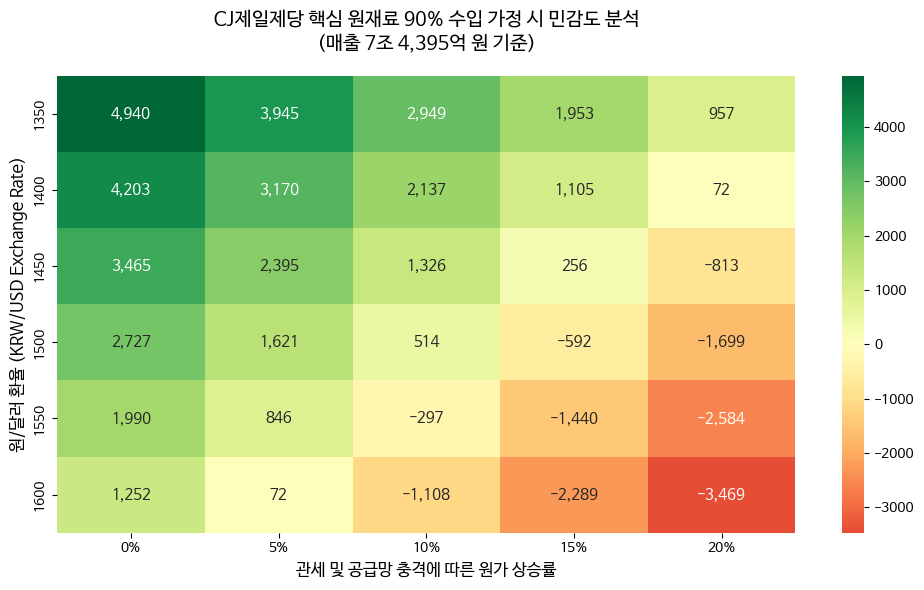


[Conclusion]
1. 기준 매출액: 7조 4,395억 원
2. 최악의 시나리오 영업이익: -3,469억 원


In [3]:
# @title
# ==============================================================================
# [0. 환경 설정] 폰트 설치 및 라이브러리 임포트
# ==============================================================================
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
!pip install OpenDartReader
import OpenDartReader

plt.rc('font', family='NanumBarunGothic')
plt.rcParams['axes.unicode_minus'] = False

# ==============================================================================
# [1. 데이터 수집] DART API 연동
# ==============================================================================
api_key = 'YOUR_DART_API_KEY_HERE'
dart = OpenDartReader(api_key)

def get_real_data(corp_code):
    print(f"📡 [DART] CJ제일제당(097950) 2025년 3분기 실적 수집 중...")
    try:
        df = dart.finstate(corp_code, 2025, reprt_code='11014')
        if df is None: return None

        sales_row = df.loc[(df['fs_div']=='CFS') & (df['account_nm'].isin(['매출액', '수익'])) , 'thstrm_amount']
        op_row = df.loc[(df['fs_div']=='CFS') & (df['account_nm']=='영업이익'), 'thstrm_amount']

        sales = int(sales_row.values[0].replace(',',''))
        op_profit = int(op_row.values[0].replace(',',''))

        print(f"✅ 데이터 수신 완료")
        return sales, op_profit

    except Exception as e:
        print(f"⚠️ 에러 발생: {e}")
        return None

# ==============================================================================
# [2. 분석 로직]
# ==============================================================================
real_data = get_real_data('097950')

if real_data:
    real_sales, real_op_profit = real_data

    # 가정: 원재료 비중 31.95%, 수입 의존도 90%
    MATERIAL_COST_RATIO = 0.3195
    IMPORT_EXPOSURE_RATIO = 0.90

    risk_exposure_amount = real_sales * MATERIAL_COST_RATIO * IMPORT_EXPOSURE_RATIO
    fixed_cost = (real_sales - real_op_profit) - risk_exposure_amount

    # 시뮬레이션 범위
    current_rate = 1450
    rates = np.arange(1350, 1610, 50)
    price_hikes = np.arange(0, 0.21, 0.05)

    results = []
    for r in rates:
        row = []
        for h in price_hikes:
            new_import_cost = risk_exposure_amount * (r / current_rate) * (1 + h)
            new_op_profit = real_sales - (new_import_cost + fixed_cost)
            row.append(new_op_profit / 100000000)
        results.append(row)

    # ==========================================================================
    # [3. 시각화] (단위 변환 로직 추가됨)
    # ==========================================================================
    df_res = pd.DataFrame(results, index=rates, columns=[f"{int(x*100)}%" for x in price_hikes])

    plt.figure(figsize=(10, 6))

    # 📌 [핵심 수정] 억 단위 숫자를 '조'와 '억'으로 분리하는 로직
    sales_ok = int(real_sales / 100000000) # 전체 억 단위 (예: 74395)
    trillion = sales_ok // 10000           # 조 단위 (예: 7)
    hundred_mn = sales_ok % 10000          # 나머지 억 단위 (예: 4395)

    # 포맷팅: 7조 4,395억
    title_sales_str = f"{trillion}조 {hundred_mn:,}억"

    # 히트맵 그리기
    sns.heatmap(df_res, annot=True, fmt=",.0f", cmap="RdYlGn", center=0, annot_kws={"size": 11})

    plt.title(f"CJ제일제당 핵심 원재료 90% 수입 가정 시 민감도 분석\n(매출 {title_sales_str} 원 기준)", fontsize=14, pad=20)
    plt.xlabel("관세 및 공급망 충격에 따른 원가 상승률", fontsize=12)
    plt.ylabel("원/달러 환율 (KRW/USD Exchange Rate)", fontsize=12)

    plt.tight_layout()
    plt.show()

    # 결과 요약 출력
    print(f"\n[Conclusion]")
    print(f"1. 기준 매출액: {title_sales_str} 원")
    print(f"2. 최악의 시나리오 영업이익: {int(df_res.iloc[-1, -1]):,}억 원")

else:
    print("❌ 데이터 수집 실패")